In [78]:
#Imports
import sys
sys.path.append('.')
sys.path.append('..')


import os
from experiments.config import predict_config

import pickle 
import pandas as pd
import numpy as np 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [79]:
config = predict_config.B_CNN


In [80]:
#Load feature vecotrs
features_save_name = 'multi_label_prediction-V11_annotated-features'

with open(os.path.join(config.get('evaluation_path'), features_save_name), "rb") as f_in:
    stored_data = pickle.load(f_in)
    stored_ids = stored_data['image_ids']
    stored_coarse_features = stored_data['coarse_features']
    stored_fine_features = stored_data['fine_features']
    stored_predictions = stored_data['prediction']


In [81]:
stored_df = pd.DataFrame({'image_id': stored_ids, 'coarse_features': str(stored_coarse_features),
                          'fine_features': str(stored_fine_features)})

In [82]:
all_encodings = []  # Initialize an empty DataFrame
index = 0
for id in stored_ids:
    coarse_feat = stored_coarse_features[index]
    fine_feat = stored_fine_features[index]
    
    data = {'image_id': int(id), 'fine_feat': str(fine_feat), 'coarse_feat': str(coarse_feat)}
    #row_df = pd.DataFrame(data, index=[index])  # Create a DataFrame from the dictionary
    all_encodings.append(data)  # Append the row DataFrame to the main DataFrame
    index += 1
    
stored_df = pd.DataFrame(all_encodings)    

    

In [85]:
#load the true labels
all_labels = pd.read_csv(os.path.join(config.get('root_data'), f'V11/metadata/annotations_combined.csv'), usecols=['image_id', 'surface', 'smoothness'])
all_labels = all_labels[~all_labels['smoothness'].isna()]
all_labels = all_labels[~all_labels['surface'].isna()]



In [86]:
#adding true labels to our stored_df

stored_df = pd.merge(stored_df, all_labels, how="left", left_on="image_id",
                     right_on="image_id")


            image_id                                          fine_feat  \
0   1108901116248517  tensor([0.0075, 0.0094, 0.0094,  ..., 0.0231, ...   
1   1132150697721186  tensor([0.0066, 0.0083, 0.0084,  ..., 0.0233, ...   
2   1156688858072710  tensor([0.0078, 0.0083, 0.0091,  ..., 0.0232, ...   
3   1165154770939283  tensor([0.0067, 0.0084, 0.0085,  ..., 0.0214, ...   
4   1175113039579141  tensor([0.0071, 0.0082, 0.0085,  ..., 0.0223, ...   
..               ...                                                ...   
91   627552065206076  tensor([0.0074, 0.0091, 0.0090,  ..., 0.0221, ...   
92   635878951880307  tensor([0.0078, 0.0096, 0.0094,  ..., 0.0226, ...   
93   669770768319743  tensor([0.0077, 0.0092, 0.0092,  ..., 0.0234, ...   
94   688995148924661  tensor([0.0077, 0.0094, 0.0094,  ..., 0.0231, ...   
95   692920291542340  tensor([0.0066, 0.0083, 0.0082,  ..., 0.0232, ...   

                                          coarse_feat smoothness  surface  
0   tensor([0.0205, 0.0

In [94]:
#separating our stored_df in valid and training data
predictions_save_name = 'multi_label_prediction-V11_annotated-20240507_155238.csv'
all_predictions = pd.read_csv(os.path.join(config.get('root_predict'), predictions_save_name))
all_predictions = all_predictions.rename(columns = {"Image":"image_id"})
all_predictions['image_id'] = all_predictions['image_id'].astype('int64')
valid_predictions = all_predictions[all_predictions['is_in_validation'] == 1]
train_predictions = all_predictions[all_predictions['is_in_validation'] == 0]

all_predictions



,image_id,Coarse_Prediction,Coarse_Probability,Fine_Prediction,Fine_Probability,is_in_validation
0,1108901116248517,concrete,0.209083,unpaved__intermediate,0.058194,1.0
1,1132150697721186,concrete,0.209137,unpaved__intermediate,0.058193,1.0
2,1156688858072710,concrete,0.209046,unpaved__intermediate,0.058191,0.0
3,1165154770939283,concrete,0.209116,unpaved__intermediate,0.058191,1.0
4,1175113039579141,concrete,0.209115,unpaved__intermediate,0.058196,1.0
...,...,...,...,...,...,...
91,627552065206076,concrete,0.209066,unpaved__intermediate,0.058192,0.0
92,635878951880307,concrete,0.209074,unpaved__intermediate,0.058195,1.0
93,669770768319743,concrete,0.209078,unpaved__intermediate,0.058195,1.0
94,688995148924661,concrete,0.209151,unpaved__intermediate,0.058193,1.0


In [134]:
# merge all_predictions with stored_df
valid_df = pd.merge(stored_df, all_predictions[all_predictions['is_in_validation'] == 1],
                     how='inner', on='image_id')

train_df = pd.merge(stored_df, all_predictions[all_predictions['is_in_validation'] == 0],
                     how='inner', on='image_id')

In [135]:
id_position = {image_id: position for position, image_id in enumerate(stored_ids)}
valid_df['image_id'] = valid_df['image_id'].astype('str')
valid_df['position'] = valid_df['image_id'].map(id_position)
train_df['image_id'] = train_df['image_id'].astype('str')
train_df['position'] = train_df['image_id'].map(id_position)


In [156]:
validation_input_coarse_tsne = stored_coarse_features[valid_df['position'].to_list()]
validation_labels_coarse_tsne = valid_df['surface'].to_list()

train_input_coarse_tsne = stored_coarse_features[train_df['position'].to_list()]
train_labels_coarse_tsne = train_df['surface'].to_list()

validation_input_fine_tsne = stored_fine_features[valid_df['position'].to_list()]
validation_labels_fine_tsne = valid_df['surface'].to_list()

train_input_fine_tsne = stored_fine_features[train_df['position'].to_list()]
train_labels_fine_tsne = train_df['surface'].to_list()




In [157]:


tsne_coarse_valid = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, random_state=config.get('seed')).fit_transform(validation_input_coarse_tsne)
tsne_coarse_train = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=config.get('seed')).fit_transform(train_input_coarse_tsne)

tsne_fine_valid = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, random_state=config.get('seed')).fit_transform(validation_input_fine_tsne)
tsne_fine_train = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=config.get('seed')).fit_transform(train_input_fine_tsne)


In [153]:
from sklearn.preprocessing import LabelEncoder

def create_plot(tsne_data, tsne_label, flag):
    label_encoder = LabelEncoder()
    scatter_labels_encoded = label_encoder.fit_transform(tsne_label)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=scatter_labels_encoded, cmap='viridis', s=10)
    plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Surface Type').set_ticklabels(label_encoder.classes_)
    plt.title('t-SNE coarse features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(os.path.join(config.get('evaluation_path'), f'{flag}_tsne_plot_validation.jpeg'))

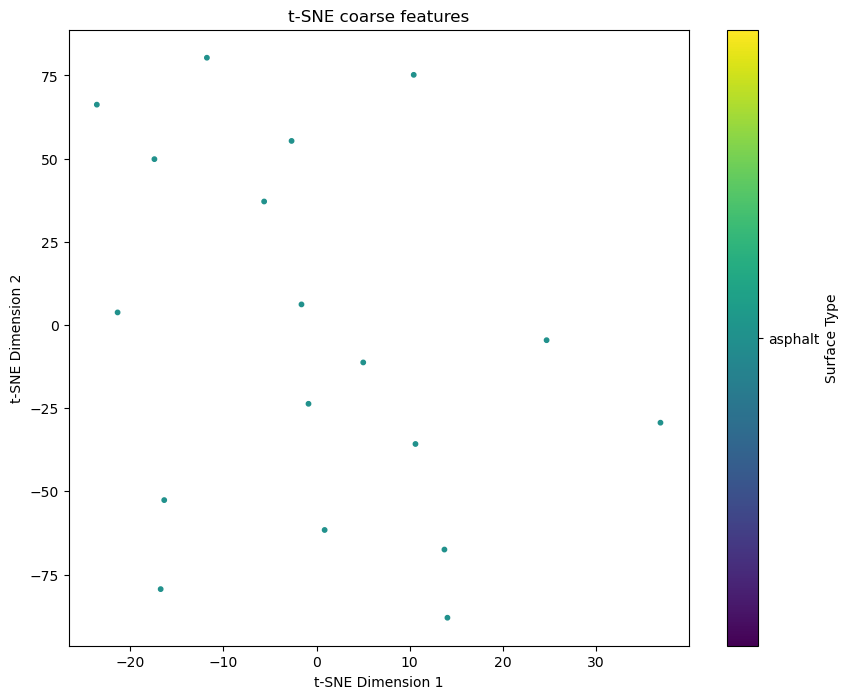

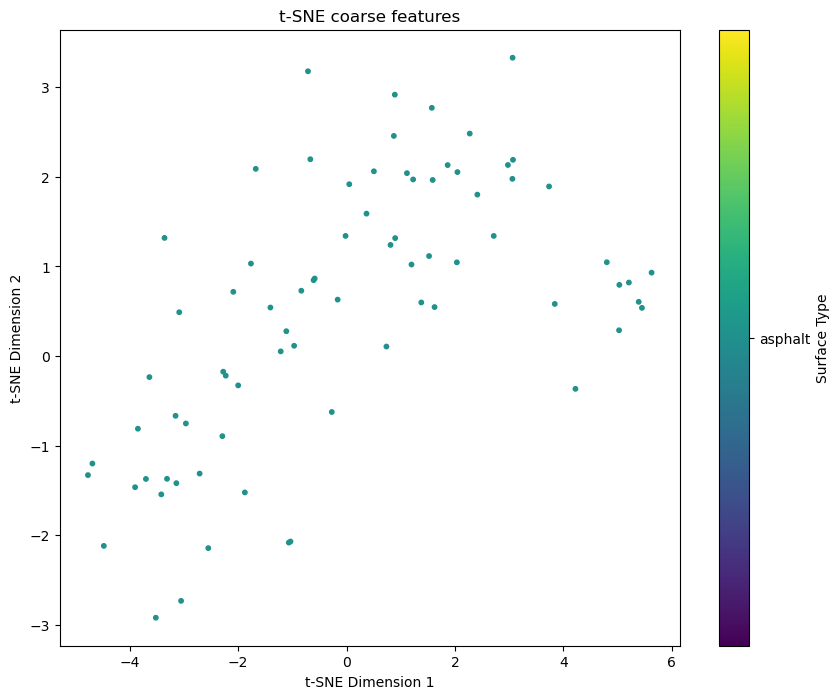

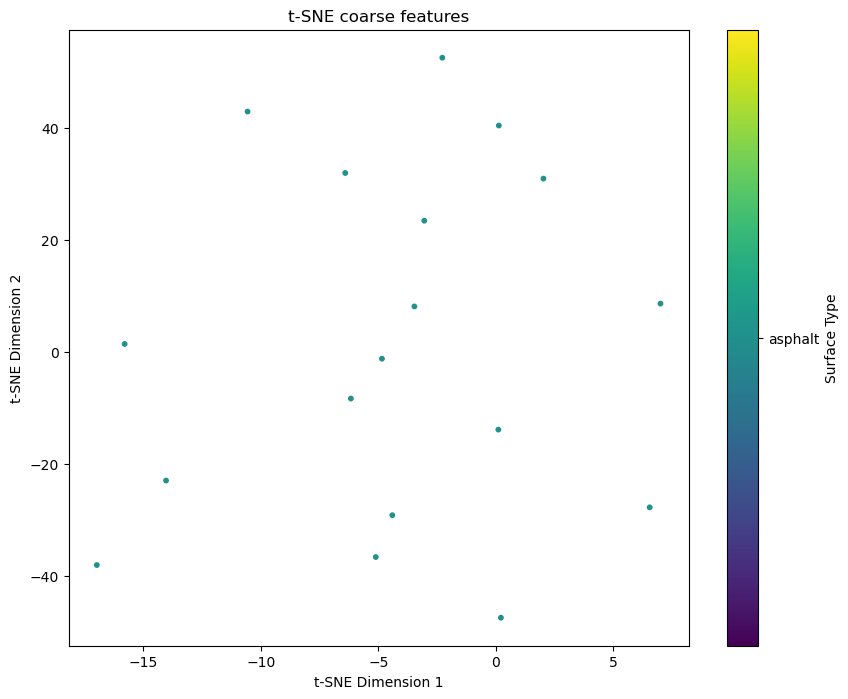

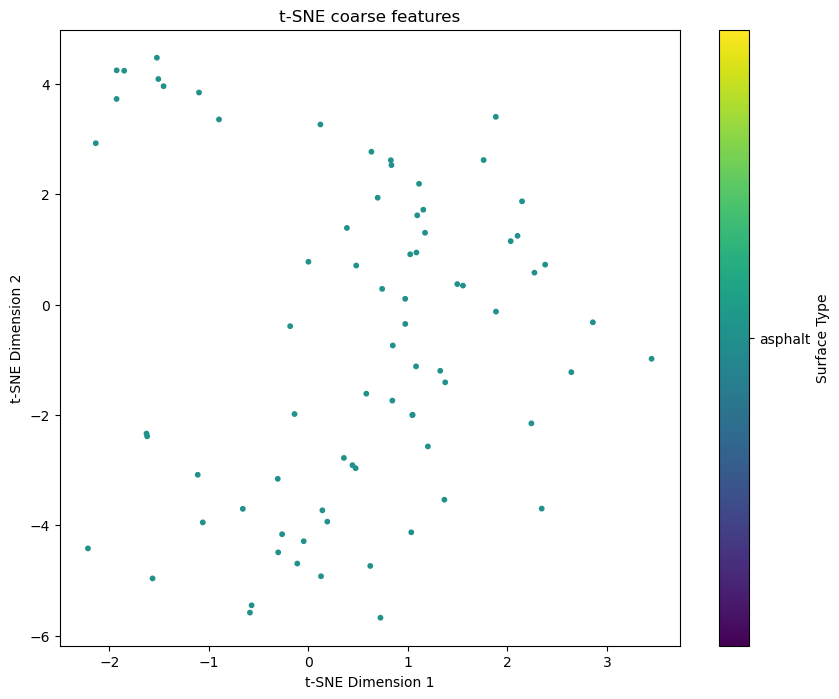

In [158]:
create_plot(tsne_coarse_train, train_labels_coarse_tsne, 'train_coarse')
create_plot(tsne_coarse_valid, validation_labels_coarse_tsne, 'valid_coarse')

create_plot(tsne_fine_train, train_labels_fine_tsne, 'train_fine')
create_plot(tsne_fine_valid, validation_labels_fine_tsne, 'valid_fine')


